In [1]:
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import time
import logging

logging.basicConfig(level=logging.INFO)

import sys
sys.path.append('./psd_models')

from psd_optim import PSDRegressor
from psd_utils import make_features, PSD_func


### Utilities

In [2]:
from scipy.linalg import sqrtm

# Transport map between Gaussian measures (to generate PSD geodesics)
def monge(A, B, pinv = False):
    sB = np.real(sqrtm(B))
    sBAB = np.real(sqrtm(sB @ A @ sB))
    if pinv:
        sBABi = np.linalg.pinv(sBAB)
    else:
        sBABi = np.linalg.inv(sBAB)
    return sB @ sBABi @ sB


# Functions to interpolate colors in plots
def interp_tuple(xs,ys, t):
     return tuple((1 - t) * x + t * y for x, y in zip(xs, ys))
  
  
def interp_cmap(cm1, cm2, t = 0.5, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    cdict = {'red':[], 'green':[], 'blue':[]}
    for i in range(len(cm1._segmentdata['blue'])):
        cdict['blue'].append(interp_tuple(cm1._segmentdata['blue'][i], cm2._segmentdata['blue'][i], t))
    for i in range(len(cm1._segmentdata['red'])):
        cdict['red'].append(interp_tuple(cm1._segmentdata['red'][i], cm2._segmentdata['red'][i], t))
    for i in range(len(cm1._segmentdata['green'])):
        cdict['green'].append(interp_tuple(cm1._segmentdata['green'][i], cm2._segmentdata['green'][i], t))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


### Generate some data

In [3]:
n = 12
dim = 2

X = np.linspace(0, 1, n).reshape(-1, 1)

# Random covariance matrices 
np.random.seed(456)

dim = 2

La = np.random.randn(dim, dim) 
Lb = np.random.randn(dim, dim)

A = La @ La.T / dim + 1e-2 * np.eye(dim)
B = Lb @ Lb.T / dim + 1e-2 * np.eye(dim)

# Bures geodesic
Tab = monge(A, B, pinv=True)
C = np.array([(1 - t) * np.eye(dim) + t * Tab for t in X])
M = C @ A @ C


<Figure size 432x288 with 0 Axes>

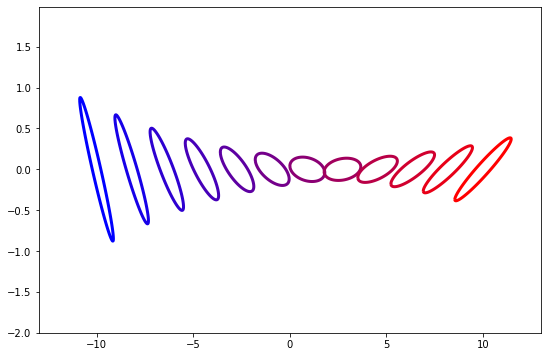

In [4]:
# Plot the data

import scipy.stats

if dim == 2:
    
    plt.clf()
    fig = plt.figure(figsize=(9, 6))
    
    x, y = np.mgrid[-13:13:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y

    for i in range(n):

        rv1 = scipy.stats.multivariate_normal(np.array([(X[i].item() - .5) * 20, 0]), M[i])
        plt.contour(x, y, rv1.pdf(pos), levels = [.6], 
                    cmap=interp_cmap(plt.cm.winter, plt.cm.autumn, X[i].item(), False), linewidths=3)

    plt.show()

## Run optimization


In [5]:
# Model hyperparameters

bw = .1
lbda_1 = 0.
lbda_2 = 1e-6
kernel_type = 'exponential'

# Optimization parameters 

max_iter = 100000
precision = 1e-7
report_interval = 1000

In [6]:
psd_reg = PSDRegressor(bw, lbda_1, lbda_2, max_iter=max_iter, precision=precision,
                       kernel_type=kernel_type, eps=1e-12)

psd_reg.fit(X, M, report_interval=report_interval, verbose=True)

INFO:root:iter 0:	loss: 0.00e+00	grad norm: 5.83e+00
INFO:root:iter 79:	loss: -1.50e-06	grad norm: 4.44e-08
INFO:root:Precision 1.00e-07 reached in 1.50e-02 seconds



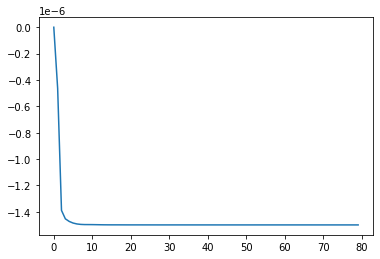

In [7]:
plt.plot(psd_reg.losses_)

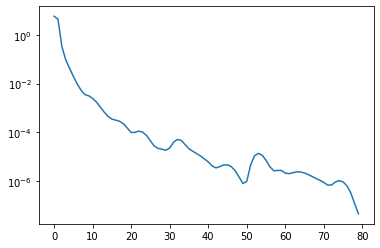

In [8]:
plt.plot(psd_reg.grad_norms_)
plt.yscale('log')

## Plot results

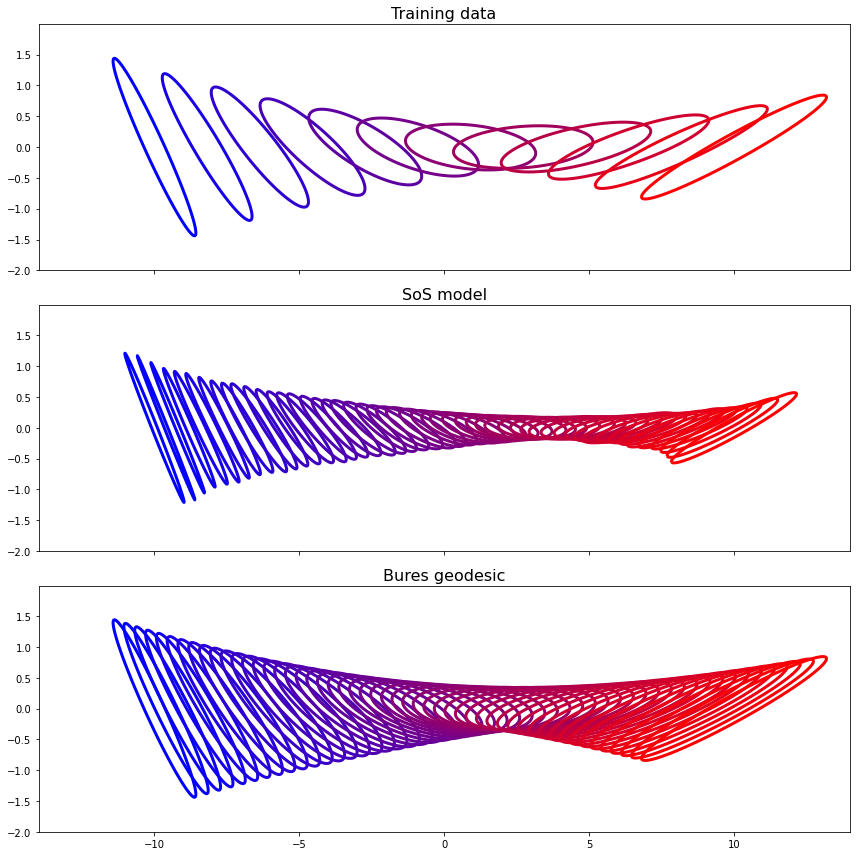

In [9]:
import scipy.stats

f, axes = plt.subplots(3, 1, figsize = (12, 12), sharex = True)

ax1, ax2, ax3 = axes

# Sample new points
nsample = 51
Y = np.linspace(0, 1, nsample).reshape(-1, 1)

if dim == 2:
    
    x, y = np.mgrid[-14:14:0.01, -2:2:0.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    
    for i in range(n):

        # Plot training data
        C_ = (1 - X[i]) * np.eye(dim) + X[i] * Tab 
        M_ = C_ @ A @ C_
        rv1 = scipy.stats.multivariate_normal(np.array([(X[i].item() - .5) * 20, 0]), M_)
        ax1.contour(x, y, rv1.pdf(pos), levels=[.1], 
                    cmap=interp_cmap(plt.cm.winter, plt.cm.autumn, X[i].item(), False),
                    linewidths=3)


    for i in range(nsample):

        # Plot SoS model
        rv2 = scipy.stats.multivariate_normal(np.array([(Y[i].item() - .5) * 20, 0]),
                                              psd_reg.predict(np.array(Y[i])))
        ax2.contour(x, y, rv2.pdf(pos), levels=[.1], 
                    cmap=interp_cmap(plt.cm.winter, plt.cm.autumn, Y[i].item(), False), 
                    linewidths=3)

        # Plot ground truth
        C_ = (1 - Y[i]) * np.eye(dim) + Y[i] * Tab 
        M_ = C_ @ A @ C_
        rv3 = scipy.stats.multivariate_normal(np.array([(Y[i].item() - .5) * 20, 0]), M_)
        ax3.contour(x, y, rv3.pdf(pos), levels=[.1], 
                    cmap=interp_cmap(plt.cm.winter, plt.cm.autumn, Y[i].item(), False),
                    linewidths=3)

        
ax1.set_title('Training data', fontsize=16)    
ax2.set_title('SoS model', fontsize=16)  
ax3.set_title('Bures geodesic', fontsize=16)  

plt.tight_layout()
plt.show()